In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

import numpy as np
sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
# !rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-12-04 17:05:23.525205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 17:05:23.623376: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 17:05:24.198600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_ensemble


In [2]:
oof_xgb = pd.read_csv(f'/kaggle/output/exp_138/oof.csv')
oof_lgb = pd.read_csv(f'/kaggle/output/exp_139/oof.csv')

oof_xgb = pd.concat([
    oof_xgb[oof_xgb["event"]=="wakeup"].rename(columns={"score": "wakeup_oof"}).drop(columns=["event"]).reset_index(drop=True),
    oof_xgb[oof_xgb["event"]=="onset"].rename(columns={"score": "onset_oof"})[["onset_oof"]].reset_index(drop=True),
], axis=1)
oof_lgb = pd.concat([
    oof_lgb[oof_lgb["event"]=="wakeup"].rename(columns={"score": "wakeup_oof"}).drop(columns=["event"]).reset_index(drop=True),
    oof_lgb[oof_lgb["event"]=="onset"].rename(columns={"score": "onset_oof"})[["onset_oof"]].reset_index(drop=True),
], axis=1)

oof_xgb["wakeup_oof"] = ((
    oof_xgb["wakeup_oof"]
    + oof_lgb["wakeup_oof"]
) / 2).astype(np.float16)

oof_xgb["onset_oof"] = ((
    oof_xgb["onset_oof"]
    + oof_lgb["onset_oof"]
) / 2).astype(np.float16)


del oof_lgb
gc.collect()
oof_xgb.head()

,series_id,step,wakeup_oof,onset_oof
0,038441c925bb,461,-0.007927,-0.013428
1,038441c925bb,473,-0.009399,-0.011658
2,038441c925bb,485,-0.006920,-0.012360
3,038441c925bb,497,-0.001107,-0.012093
4,038441c925bb,509,0.027267,-0.015610


In [3]:
oof_gru = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_gru_v2 = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru_v2"]["execution"]["best_exp_id"]}/oof.parquet')
oof_wave = pd.read_parquet(f'/kaggle/output/{CFG["patch_wavenet_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_wave_v2 = pd.read_parquet(f'/kaggle/output/exp_161/oof.parquet')
oof_1d = pd.read_parquet(f'/kaggle/output/{CFG["patch_1dcnn_gru"]["execution"]["best_exp_id"]}/oof.parquet')

oof_gru["wakeup_oof"] = ((
    oof_gru["wakeup_oof"] 
    + oof_gru_v2["wakeup_oof"]
    + oof_wave["wakeup_oof"]
    + oof_wave_v2["wakeup_oof"]
    + oof_1d["wakeup_oof"]
) / 5).astype(np.float16)

oof_gru["onset_oof"] = ((
    oof_gru["onset_oof"] 
    + oof_gru_v2["onset_oof"]
    + oof_wave["onset_oof"]
    + oof_wave_v2["onset_oof"]
    + oof_1d["onset_oof"]
) / 5).astype(np.float16)

del oof_gru_v2, oof_wave, oof_wave_v2, oof_1d
gc.collect()

26

In [4]:
oof_tubo_based = pd.read_parquet(f'/kaggle/output/tubo_based/exp031_oof.parquet')
oof_tubo_based_v2 = pd.read_parquet(f'/kaggle/output/tubo_based/exp061_oof.parquet')
oof_tubo_based["wakeup_oof"] = ((oof_tubo_based["wakeup_oof"] + oof_tubo_based_v2["wakeup_oof"]) / 2).astype(np.float16)
oof_tubo_based["onset_oof"] = ((oof_tubo_based["onset_oof"] + oof_tubo_based_v2["onset_oof"]) / 2).astype(np.float16)
oof_tubo_based.head()

,series_id,step,onset_oof,wakeup_oof
0,05e1944c3818,0,0.030319,0.028763
1,05e1944c3818,1,0.024597,0.022461
2,05e1944c3818,2,0.013176,0.009842
3,05e1944c3818,3,0.007889,0.003525
4,05e1944c3818,4,0.008736,0.003513


In [5]:
dfs = []
for seires_id, df_tubo_based in tqdm(oof_tubo_based.groupby("series_id")):
    df_gru = oof_gru[oof_gru["series_id"]==seires_id]
    df_xgb = oof_xgb[oof_xgb["series_id"]==seires_id]
    df = df_tubo_based

    # tubo based
    df["onset_oof_tubo_based"] = df["onset_oof"] / 1.5
    df["wakeup_oof_tubo_based"] = df["wakeup_oof"] / 1.5

    # gru
    df["onset_oof_gru"] = df["step"].map(df_gru.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_gru"] = df["step"].map(df_gru.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # xgb
    df["onset_oof_xgb"] = df["step"].map(df_xgb.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_xgb"] = df["step"].map(df_xgb.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    df["wakeup_oof"] = (
          df["wakeup_oof_gru"] * 0.5
        + df["wakeup_oof_xgb"] * 0.2
        + df["wakeup_oof_tubo_based"] * 0.3
    ) 
    df["onset_oof"] = (
          df["onset_oof_gru"] * 0.5
        + df["onset_oof_xgb"] * 0.2
        + df["onset_oof_tubo_based"] * 0.3
    ) 

    # df["wakeup_oof"] = df["wakeup_oof_gru"] * 0.6 + df["wakeup_oof_xgb"] * 0.2 + df["wakeup_oof_lgb"] * 0.2 * df["wakeup_oof_tubo_based"] * 0
    # df["onset_oof"] = df["onset_oof_gru"] * 0.6 + df["onset_oof_xgb"] * 0.2 + df["onset_oof_lgb"] * 0.2 * df["onset_oof_tubo_based"] * 0

    df = df[["series_id", "step", "wakeup_oof", "onset_oof"]].reset_index(drop=True)
    dfs.append(df)
oof_df = pd.concat(dfs)
oof_df["wakeup_oof"] = oof_df["wakeup_oof"].astype(float)
oof_df["onset_oof"] = oof_df["onset_oof"].astype(float)
oof_df.to_parquet(os.path.join(CFG["output_dir"], "oof.parquet"), index=False)
del dfs
gc.collect()

100%|██████████| 277/277 [03:00<00:00,  1.54it/s]


0

2792849

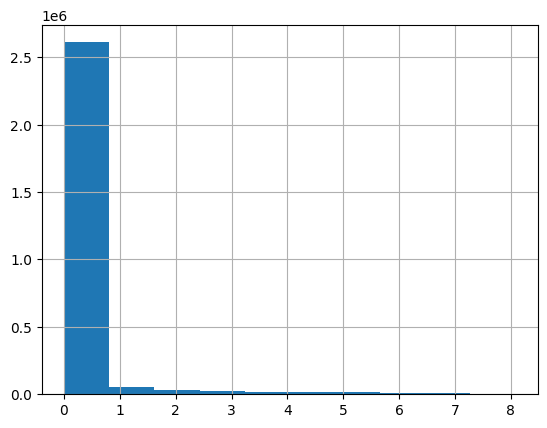

In [6]:
oof_df = oof_df[oof_df["step"] % 12 == 6]

dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.005]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.005]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["score"].hist()
len(train)

In [7]:
from multiprocessing import Pool

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:07<00:00, 35.51it/s]


In [8]:
unused_series_ids = ['0ce74d6d2106', '0f9e60a8e56d', '154fe824ed87', '2fc653ca75c7',
       '390b487231ce', '44a41bba1ee7', '89c7daa72eee', 'a3e59c2ce3f6',
       'c5d08fc3e040', 'c7b1283bb7eb', 'e11b9d69f856', 'efbfc4526d58',
       'f8a8da8bdd00']

# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[~labels["series_id"].isin(unused_series_ids)]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.8271


event   tolerance
onset   12           0.445431
        36           0.747706
        60           0.815648
        90           0.849105
        120          0.873314
        150          0.883263
        180          0.895241
        240          0.905867
        300          0.910803
        360          0.916956
wakeup  12           0.466566
        36           0.762666
        60           0.826866
        90           0.851200
        120          0.872298
        150          0.880709
        180          0.893059
        240          0.904917
        300          0.916383
        360          0.923387
dtype: float64